In [1]:
# installing opencv, keras and the image-feature of huggingface to work with image datasets
!pip install opencv-python datasets[vision] keras matplotlib tensorflow-cpu

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/f5/d0/2e455d894ec0d6527e662ad55e70c04f421ad83a6fd0a54c3dd73c411282/opencv_python-4.8.0.76-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for datasets[vision] from https://files.pythonhosted.org/packages/09/7e/fd4d6441a541dba61d0acb3c1fd5df53214c2e9033854e837a99dd9e0793/datasets-2.14.5-py3-none-any.whl.metadata
  Obtaining dependency information for keras from https://files.pythonhosted.org/packages/fe/58/34d4d8f1aa11120c2d36d7ad27d0526164b1a8ae45990a2fede31d0e59bf/keras-2.14.0-py3-none-any.whl.metadata
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/b5/24/aaccf324ce862bb82277e8814d2aebbb2a2c160d04e95aa2b8c9dc3137a9/matplotlib-3.8.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dep

In [2]:
# import modules
import datasets
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

/home/ucloud/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-26 10:51:33.351070: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# this line of code loads the WikiArt dataset from the Huggingface Hub. Loads the training data
# the streaming parameter is smart, we don't need to download the data, it iterates over it
wikiart = datasets.load_dataset("huggan/wikiart", split='train', streaming=True).take(2200)

Resolving data files: 100%|██████████| 72/72 [00:27<00:00,  2.63it/s]


In [17]:
from functools import partial

# the function returns an interable object, here the dataset using the 'yield from' operator, which converts an object to a generator (which is iterable)
def gen_from_iterable_dataset(iterable_ds):
    yield from iterable_ds

# converting the IterableDataset to a dataset able to be saved to a local disk
ds = datasets.Dataset.from_generator(partial(gen_from_iterable_dataset, wikiart), features=wikiart.features)

Generating train split: 2200 examples [01:09, 31.55 examples/s]


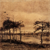

In [6]:
# !important! index with row first so you don't have to decode the whole column!
# otherwise ram usage is gonna go through the roof & the session will crash
im1 = ds[0]["image"]
im1.resize((50,50))

In [18]:
ds.features

{'image': Image(decode=True, id=None),
 'artist': ClassLabel(names=['Unknown Artist', 'boris-kustodiev', 'camille-pissarro', 'childe-hassam', 'claude-monet', 'edgar-degas', 'eugene-boudin', 'gustave-dore', 'ilya-repin', 'ivan-aivazovsky', 'ivan-shishkin', 'john-singer-sargent', 'marc-chagall', 'martiros-saryan', 'nicholas-roerich', 'pablo-picasso', 'paul-cezanne', 'pierre-auguste-renoir', 'pyotr-konchalovsky', 'raphael-kirchner', 'rembrandt', 'salvador-dali', 'vincent-van-gogh', 'hieronymus-bosch', 'leonardo-da-vinci', 'albrecht-durer', 'edouard-cortes', 'sam-francis', 'juan-gris', 'lucas-cranach-the-elder', 'paul-gauguin', 'konstantin-makovsky', 'egon-schiele', 'thomas-eakins', 'gustave-moreau', 'francisco-goya', 'edvard-munch', 'henri-matisse', 'fra-angelico', 'maxime-maufra', 'jan-matejko', 'mstislav-dobuzhinsky', 'alfred-sisley', 'mary-cassatt', 'gustave-loiseau', 'fernando-botero', 'zinaida-serebriakova', 'georges-seurat', 'isaac-levitan', 'joaquã\xadn-sorolla', 'jacek-malczewski'

In [3]:
# the dataset can be saved locally
#ds.save_to_disk("test")
smk = datasets.load_from_disk("smk")

Preprocessing images (if using Keras Datagenerators, maybe do differently?)

In [4]:
def _resize_img(example, dimx=224, dimy=224):
    X = example['image']
    example['image'] = X.resize((dimx, dimy)) # resize image to desired dimensions
    #example['image'] = np.resize(X,(dimx, dimy))
    return example

def _normalize_img(example):
  X = example['image']
  X = X.astype('float32') / 255.0 - 0.5 # standardize pixel values
  example['image'] = X
  return example

In [5]:
tester = smk.map(_resize_img)

In [6]:
tester_1 = tester.with_format(type="numpy", columns=['image'], output_all_columns=True)

In [15]:
tester_1.features

{'title': Value(dtype='string', id=None),
 'artist': Value(dtype='string', id=None),
 'date': Value(dtype='string', id=None),
 'image': Image(decode=True, id=None)}

In [7]:
tester_2 = tester_1.map(_normalize_img)

Map:  22%|██▏       | 999/4517 [00:03<00:14, 251.00 examples/s]


ArrowInvalid: arrays to be concatenated must be identically typed, but list<item: list<item: uint8>> and list<item: uint8> were encountered.

In [23]:
tester_1.features

{'title': Value(dtype='string', id=None),
 'artist': Value(dtype='string', id=None),
 'date': Value(dtype='string', id=None),
 'image': Image(decode=True, id=None)}

array([[[186, 149, 112],
        [185, 153, 121],
        [190, 159, 127],
        ...,
        [157, 139, 121],
        [172, 147, 124],
        [142, 116,  95]],

       [[177, 143, 107],
        [178, 150, 120],
        [190, 162, 133],
        ...,
        [217, 194, 169],
        [217, 190, 167],
        [162, 136, 122]],

       [[169, 137, 104],
        [174, 149, 121],
        [192, 167, 139],
        ...,
        [213, 187, 161],
        [211, 184, 160],
        [168, 144, 125]],

       ...,

       [[188, 160, 117],
        [195, 172, 145],
        [198, 177, 143],
        ...,
        [196, 181, 153],
        [193, 173, 152],
        [193, 172, 148]],

       [[188, 160, 117],
        [197, 174, 146],
        [197, 176, 143],
        ...,
        [199, 184, 158],
        [201, 180, 161],
        [189, 167, 145]],

       [[191, 160, 114],
        [188, 163, 130],
        [197, 172, 143],
        ...,
        [205, 189, 162],
        [203, 179, 150],
        [181, 157, 131]]

In [ ]:
tester_1 = ds.with_format(type="numpy", columns=['image'], output_all_columns=True)

In [19]:
preprocessed_ds = (ds
                   .map(_resize_img)
                   .with_format(type="numpy", columns=['image'], output_all_columns=True)
                   .map(_normalize_img))

Map:  45%|████▍     | 985/2200 [02:19<00:02, 523.62 examples/s]/home/ucloud/.local/lib/python3.10/site-packages/datasets/features/image.py:332: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
Map:  49%|████▉     | 1084/2200 [05:45<28:52,  1.55s/ examples]

In [ ]:
image = preprocessed_ds[0]['image']
print(image)
# pixel values are now standardized between 0-1

[[0.7058824  0.5411765  0.3764706  ... 0.40784314 0.7254902  0.56078434]
 [0.39607844 0.7176471  0.5529412  ... 0.40784314 0.24313726 0.5372549 ]
 [0.37254903 0.20784314 0.5411765  ... 0.654902   0.49803922 0.30588236]
 ...
 [0.6        0.40784314 0.77254903 ... 0.6313726  0.44313726 0.2509804 ]
 [0.58431375 0.39607844 0.20392157 ... 0.09411765 0.54509807 0.3372549 ]
 [0.14117648 0.60784316 0.4117647  ... 0.52156866 0.32156864 0.7254902 ]]


Converting the dataset to a TensorFlow dataset after it is preprocessed

In [7]:
ds_tf = preprocessed_ds.to_tf_dataset(
            columns=["image"],
            label_cols=["image"],
            batch_size=32,
            shuffle=True
            )

/work/.venv/lib/python3.10/site-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


## Build simple encoder/decoder

In [8]:
def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten()) # flatten the tensor to 1D
    encoder.add(Dense(code_size)) # size of the final encoded vector (dense just means fully connected)

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072 (returns the product)
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [9]:
IMG_SHAPE = preprocessed_ds[0]['image'].shape
encoder, decoder = build_autoencoder(IMG_SHAPE, 200)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp, reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 200)               470600    
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 3)         472752    
                                                                 
Total params: 943352 (3.60 MB)
Trainable params: 943352 (3.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [10]:
tf.config.run_functions_eagerly(True)
history = autoencoder.fit(ds_tf, epochs=5)

Epoch 1/5
69/69 [==============================] - 12s 170ms/step - loss: 0.0284
Epoch 2/5
69/69 [==============================] - 13s 184ms/step - loss: 0.0165
Epoch 3/5
69/69 [==============================] - 13s 187ms/step - loss: 0.0137
Epoch 4/5
69/69 [==============================] - 13s 184ms/step - loss: 0.0119
Epoch 5/5
69/69 [==============================] - 13s 186ms/step - loss: 0.0107


1/1 [==============================] - 0s 24ms/step


/work/.venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


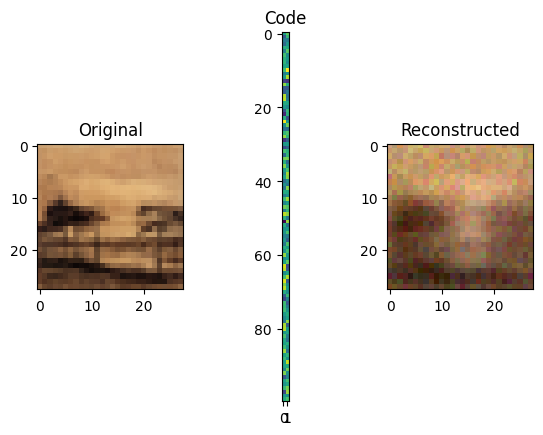

1/1 [==============================] - 0s 24ms/step


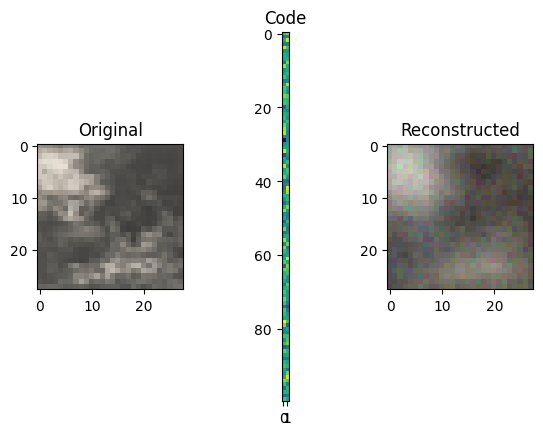

1/1 [==============================] - 0s 24ms/step


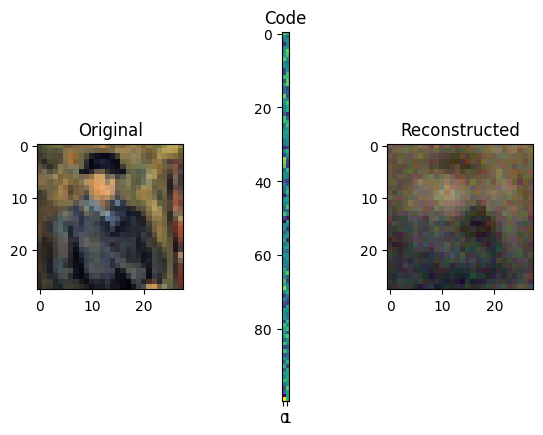

1/1 [==============================] - 0s 23ms/step


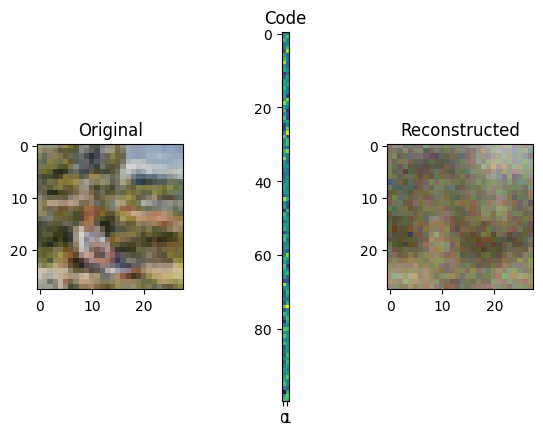

1/1 [==============================] - 0s 23ms/step


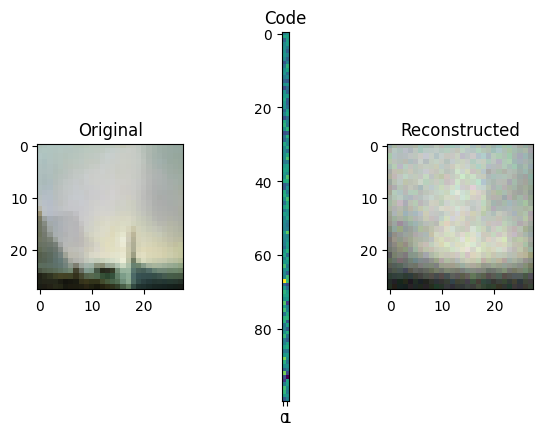

In [11]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(np.clip(img + 0.5, 0, 1))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(np.clip(reco + 0.5, 0, 1))
    plt.show()

for i in range(5):
    img = preprocessed_ds[i]['image']
    visualize(img,encoder,decoder)

## Building a deep autoencoder

In [55]:
def build_deeper_autoencoder(img_shape, code_size):
    
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten()) # flatten the tensor to 1D
    encoder.add(Dense(1200))
    encoder.add(Dense(800))
    encoder.add(Dense(400))
    encoder.add(Dense(code_size)) # size of the final encoded vector (dense just means fully connected)

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(400))
    decoder.add(Dense(800))
    decoder.add(Dense(1200))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072 (returns the product)
    decoder.add(Reshape(img_shape))

    return encoder, decoder


In [62]:
deep_encoder, deep_decoder = build_deeper_autoencoder(IMG_SHAPE, 200)

inp = Input(IMG_SHAPE)
code = deep_encoder(inp)
reconstruction = deep_decoder(code)

deep_autoencoder = Model(inp, reconstruction)
deep_autoencoder.compile(optimizer='adamax', loss='mse')

print(deep_autoencoder.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 28, 28, 3)]       0         
                                                                 
 sequential_8 (Sequential)   (None, 200)               4185000   
                                                                 
 sequential_9 (Sequential)   (None, 28, 28, 3)         4187152   
                                                                 
Total params: 8372152 (31.94 MB)
Trainable params: 8372152 (31.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [63]:
tf.config.run_functions_eagerly(True)
history = deep_autoencoder.fit(ds_tf, epochs=5)

Epoch 1/5
69/69 [==============================] - 18s 222ms/step - loss: 0.0501
Epoch 2/5
69/69 [==============================] - 17s 244ms/step - loss: 0.0198
Epoch 3/5
69/69 [==============================] - 17s 246ms/step - loss: 0.0165
Epoch 4/5
69/69 [==============================] - 17s 233ms/step - loss: 0.0146
Epoch 5/5
69/69 [==============================] - 17s 247ms/step - loss: 0.0133


1/1 [==============================] - 0s 28ms/step


/work/.venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


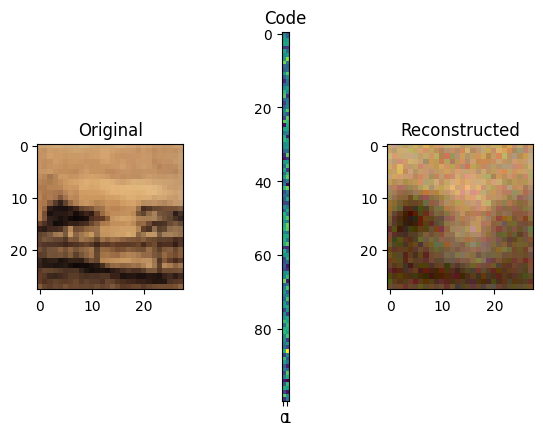

1/1 [==============================] - 0s 27ms/step


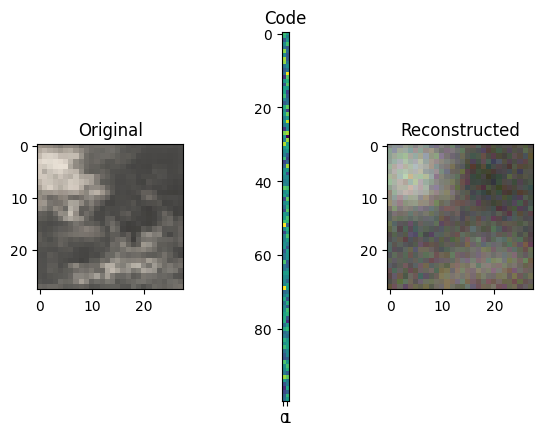

1/1 [==============================] - 0s 27ms/step


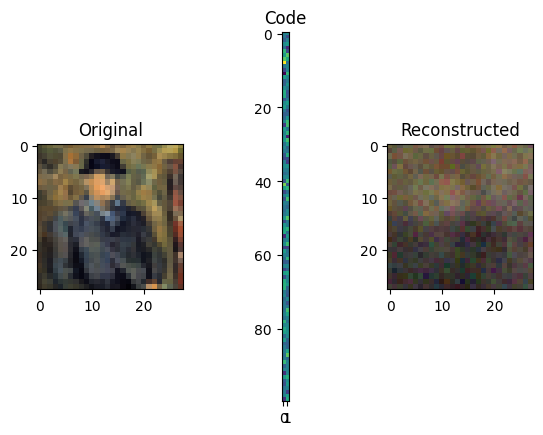

1/1 [==============================] - 0s 28ms/step


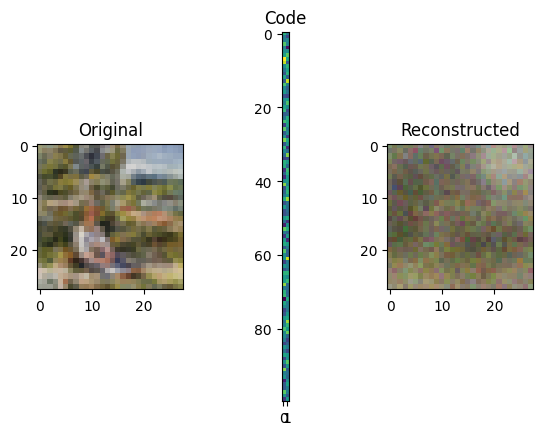

1/1 [==============================] - 0s 27ms/step


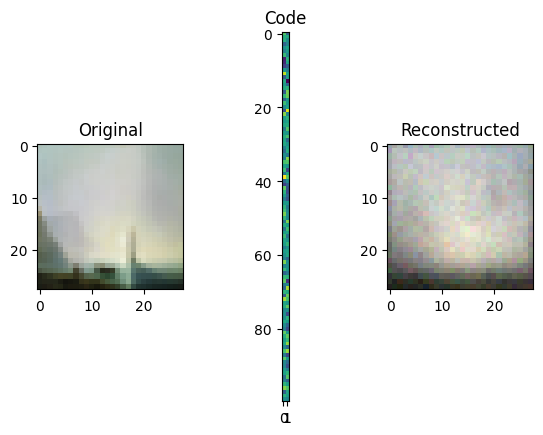

In [64]:
for i in range(5):
    img = preprocessed_ds[i]['image']
    visualize(img,deep_encoder,deep_decoder)

## Building a convolutional autoencoder 


In [40]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [65]:
def build_conv_autoencoder(img_size, depth, filters=(32, 64), latentDim=200):
    
    inputShape = (img_size, img_size, depth)
    chanDim = -1 # channel dimension index

    inputs = Input(shape=inputShape)
    x = inputs 

    # loop over filters (default is 32 and 64) (== 2 conv layers with 32 and 64 filters)
    for f in filters:
        x = Conv2D(f, (3,3), strides=2, padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(axis=chanDim)(x)

    volumeSize = K.int_shape(x) # this saves the size of the input at this stage
    x = Flatten()(x)
    latent = Dense(latentDim)(x)

    encoder = Model(inputs, latent, name = "encoder")
    
    # input is now shape of the latent encoding vector 
    latentInputs = Input(shape=(latentDim,))

    # 'un-compressing' the latent vector into its flattened size again
    x = Dense(np.prod(volumeSize[1:]))(latentInputs)
    
    # reshaping to be 3D again (8x8x64 volume)
    x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

    # loop over filters in reverse order this time (so, basically just 64 --> 32 instead of 32 --> 64)
    for f in filters[::-1]:
        # now using a Deconvolutional layer (to increase spatial dimensions)
        x = Conv2DTranspose(f, (3,3), strides=2, padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(axis=chanDim)(x)

    x = Conv2DTranspose(depth, (3,3), padding='same')(x)
    outputs = Activation("sigmoid")(x)

    # build decoder
    decoder = Model(latentInputs, outputs, name = "decoder")

    # autoencoder (encoder + decoder)

    autoencoder = Model(inputs, decoder(encoder(inputs)), name = "autoencoder")

    return (encoder, decoder, autoencoder)


In [69]:
conv_encoder, conv_decoder, conv_autoencoder = build_conv_autoencoder(28, 3)

In [70]:
conv_encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 28, 28, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        896       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 batch_normalization_8 (Bat  (None, 14, 14, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                           

In [71]:
conv_decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 200)]             0         
                                                                 
 dense_117 (Dense)           (None, 3136)              630336    
                                                                 
 reshape_12 (Reshape)        (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 14, 14, 64)        36928     
 Transpose)                                                      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_10 (Ba  (None, 14, 14, 64)        256       
 tchNormalization)                                         

In [72]:
conv_autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 28, 28, 3)]       0         
                                                                 
 encoder (Functional)        (None, 200)               647176    
                                                                 
 decoder (Functional)        (None, 28, 28, 3)         686979    
                                                                 
Total params: 1334155 (5.09 MB)
Trainable params: 1333771 (5.09 MB)
Non-trainable params: 384 (1.50 KB)
_________________________________________________________________


In [75]:
conv_autoencoder.compile(loss="mse", optimizer='adam')
H = conv_autoencoder.fit(ds_tf, epochs = 20)

Epoch 1/20
69/69 [==============================] - 18s 204ms/step - loss: 0.0398
Epoch 2/20
69/69 [==============================] - 18s 257ms/step - loss: 0.0371
Epoch 3/20
69/69 [==============================] - 18s 252ms/step - loss: 0.0366
Epoch 4/20
69/69 [==============================] - 18s 255ms/step - loss: 0.0357
Epoch 5/20
69/69 [==============================] - 18s 254ms/step - loss: 0.0351
Epoch 6/20
69/69 [==============================] - 19s 262ms/step - loss: 0.0344
Epoch 7/20
69/69 [==============================] - 18s 231ms/step - loss: 0.0338
Epoch 8/20
69/69 [==============================] - 18s 249ms/step - loss: 0.0340
Epoch 9/20
69/69 [==============================] - 18s 254ms/step - loss: 0.0335
Epoch 10/20
69/69 [==============================] - 18s 237ms/step - loss: 0.0333
Epoch 11/20
69/69 [==============================] - 18s 236ms/step - loss: 0.0328
Epoch 12/20
69/69 [==============================] - 18s 221ms/step - loss: 0.0325
Epoch 13/20
6

1/1 [==============================] - 0s 32ms/step


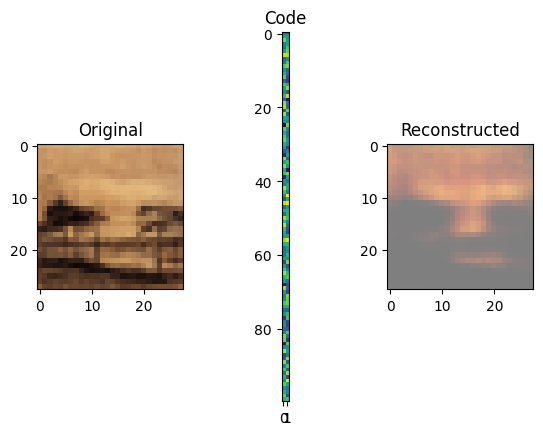

1/1 [==============================] - 0s 31ms/step


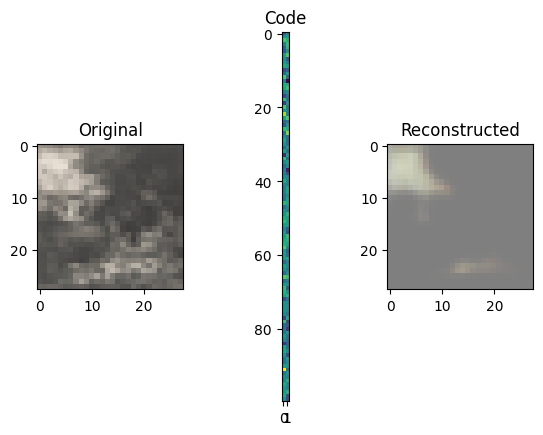

1/1 [==============================] - 0s 30ms/step


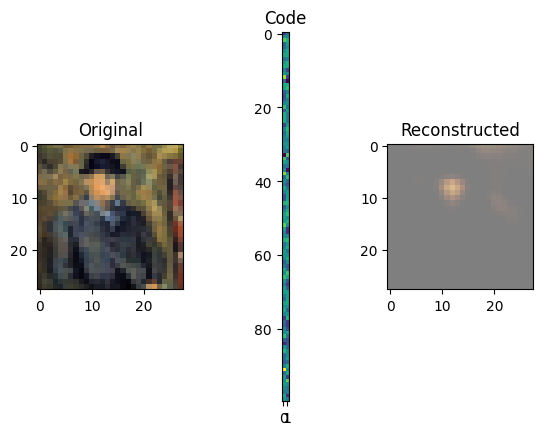

1/1 [==============================] - 0s 30ms/step


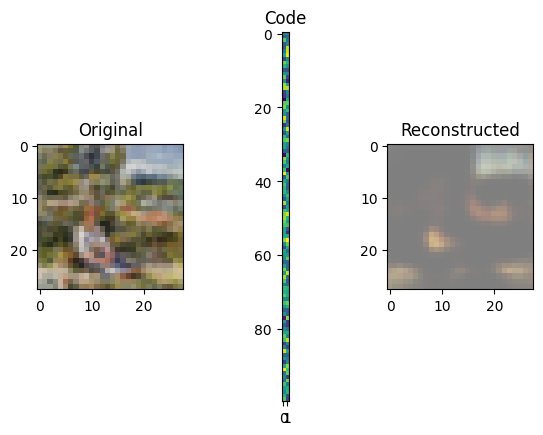

1/1 [==============================] - 0s 31ms/step


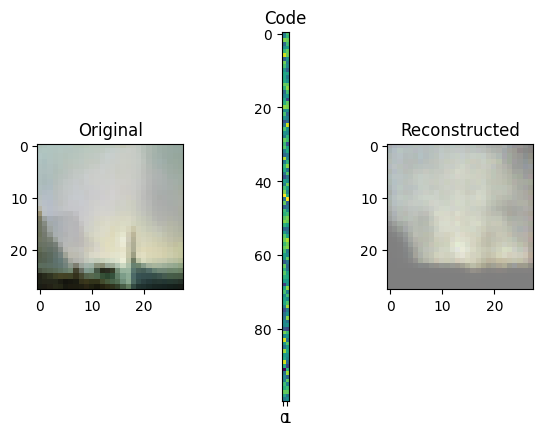

In [77]:
for i in range(5):
    img = preprocessed_ds[i]['image']
    visualize(img,conv_encoder,conv_decoder)